# Curvature demo on toy graphs

In [2]:
import os
import networkx as nx
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import logging
import seaborn as sns
import dill
import climnet.plotting.plots as cplt

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
import GraphRicciCurvature

In [3]:
np.random.seed(42)
# some networkx sample graphs
G = nx.karate_club_graph()
#G = nx.barbell_graph(20,2)
#G = nx.relaxed_caveman_graph(5,18,0.3)

n = 250
tau1 = 3
tau2 = 1.5
mu = 0.1
G = nx.LFR_benchmark_graph(n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10)

#G = nx.star_graph(10)

# edge/node betweenness are super bad for this model
sizes = [30, 40, 30, 30]
probs = [[0.5, 0.02, 0.02, 0.02], 
         [0.02, 0.5, 0.02, 0.02], 
         [0.02, 0.02, 0.50, 0.01],
         [0.02, 0.02, 0.01, 0.5]]
# sizes = [25, 25, 25,30, 25, 30]
# probs = [[0.7, 0.05, 0.05, 0.03, 0.05, 0.03], 
#          [0.05, 0.6, 0.05, 0.04, 0.04, 0.04], 
#          [0.05, 0.05, 0.6, 0.05, 0.04, 0.04],
#          [0.03, 0.04, 0.05, 0.7, 0.05, 0.05], 
#          [0.05, 0.04, 0.04, 0.05, 0.7, 0.04],
#          [0.03, 0.04, 0.04, 0.05, 0.04, 0.7]]

G = nx.stochastic_block_model(sizes, probs, seed=0)
#G = nx.relaxed_caveman_graph(5,18,0.3)
#G = nx.relaxed_caveman_graph(5,18,0.15)
G.remove_edges_from(nx.selfloop_edges(G))

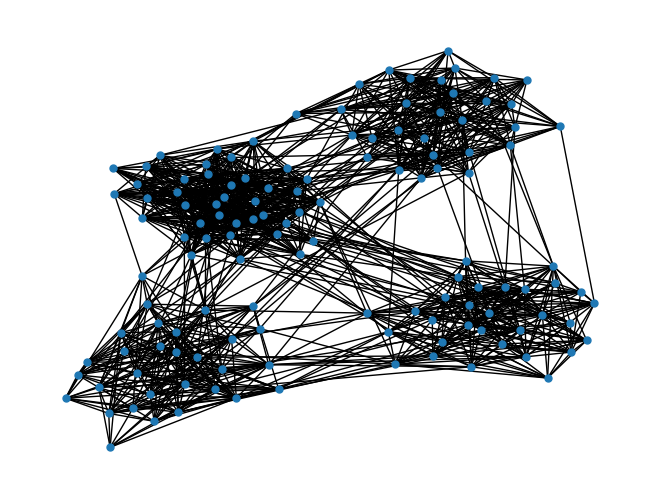

In [4]:
import climnet.plotting.plots as cplt
my_pos = nx.spring_layout(G, seed = 32)
nx.draw(G, my_pos, node_size=25)
plot_dir = '/home/strnad/data/climnet/plots/toy_model/sbm/'
cplt.save_fig(plot_dir + f"toy_model_network.pdf",
            )

In [9]:
import climnet.plotting.plots as cplt

ebc = nx.edge_betweenness_centrality(G, weight="weight")
nbc = nx.betweenness_centrality(G)
clcoeff = nx.clustering(G)


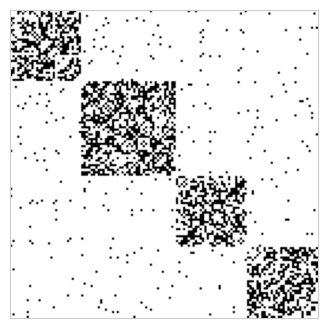

In [10]:
A_sbm = nx.to_numpy_array(G)
fig, axs = plt.subplots(1, 1, figsize=(7,4))
axs.imshow(A_sbm, cmap='Greys')  # gist_heat_r
# axs.set_title("Stochastic block model")
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)

plot_dir = '/home/strnad/data/climnet/plots/toy_model/sbm/'
cplt.save_fig(plot_dir + f"toy_model_sbm_blocks.pdf",
            )


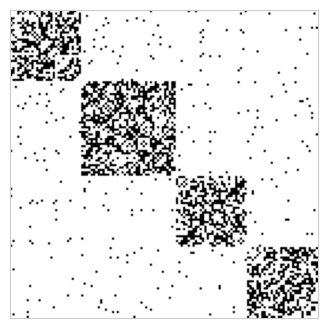

In [11]:
import random
node_mapping = dict(zip(G.nodes(), sorted(G.nodes(), key=lambda k: random.random())))
G_new = nx.relabel_nodes(G, node_mapping)
A_sbm = nx.to_numpy_array(G_new)
fig, axs = plt.subplots(1, 1, figsize=(7,4))
axs.imshow(A_sbm, cmap='Greys')  # gist_heat_r
# axs.set_title("Stochastic block model")
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)

plot_dir = '/home/strnad/data/climnet/plots/toy_model/sbm/'
cplt.save_fig(plot_dir + f"toy_model_sbm_rand.pdf",
            )

In [16]:
A_sbm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
# compute forman ricci curvature
frc = FormanRicci(G,verbose="INFO")
frc.compute_ricci_curvature()
btn = nx.edge_betweenness_centrality(frc.G, normalized=True)
nx.set_edge_attributes(frc.G, btn, "betweenness")

INFO:Edge weight not detected in graph, use "weight" as default edge weight.
INFO:Node weight not detected in graph, use "weight" as default node weight.


Forman curvature (augmented) computation done.


In [6]:
tt = time.time()
print("\n===== Compute the Ollivier-Ricci curvature of the given graph G =====")
orc = OllivierRicci(G, alpha=0.5, verbose="TRACE", proc=1, method="OTD")
orc.compute_ricci_curvature()
print("took time: %s" % (time.time()-tt))

INFO:Edge weight not detected in graph, use "weight" as default edge weight.
TRACE:Number of nodes: 105
TRACE:Number of edges: 1011
TRACE:Start to compute all pair shortest path.
TRACE:0.011204 secs for all pair by NetworKit.



===== Compute the Ollivier-Ricci curvature of the given graph G =====


INFO:0.191116 secs for Ricci curvature computation.


took time: 0.2168591022491455


In [7]:
def norm_edge_vals(G, attr='formanCurvature'):
    evals_dict = nx.get_edge_attributes(G, attr)
    evals = np.array(list(evals_dict.values()))
    edge_attr_norm = (
                2 * (evals - np.min(evals)) /
                (np.max(evals) - np.min(evals)) - 1
            )
    for n, (i, j) in enumerate(evals_dict):
                G.edges[i, j][f"{attr}_norm"] = edge_attr_norm[n]
                
my_pos = nx.spring_layout(G, seed = 32)
nodeformans = norm_edge_vals(G=frc.G)
nodericcis = norm_edge_vals(G=orc.G, attr='ricciCurvature')

## Comparison: Ollivier vs Forman vs EBC

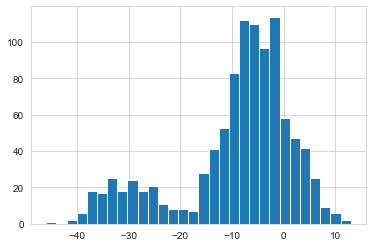

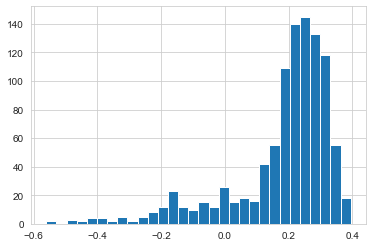

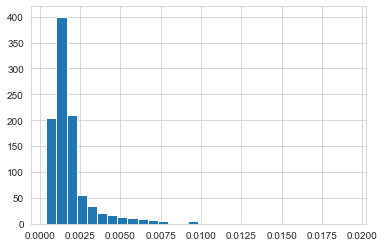

In [8]:
# forman
plt.figure()
plt.hist([frc.G[u][v]['formanCurvature'] for u,v in orc.G.edges],bins=30)
plt.show()

# ollivier
plt.figure()
plt.hist([orc.G[u][v]['ricciCurvature'] for u,v in orc.G.edges],bins=30)
plt.show()

# ebc
plt.figure()
plt.hist(list(ebc.values()),bins=30)
plt.show()

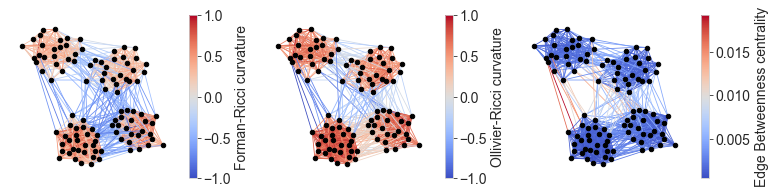

In [16]:
# Plot graph with colored edges
plt.figure(figsize=(13,3))
# Froman curvature
plt.subplot(131)
colors = [frc.G[u][v]['formanCurvature_norm'] for u,v in orc.G.edges]
vmin = min(colors)
vmax = max(colors)
cmap = cm.coolwarm
nx.draw(G, pos=my_pos, edge_color=colors, edge_cmap=cmap, vmin=vmin, vmax=vmax,width=.8, node_size=20, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, label='Forman-Ricci curvature')

# Ollivier-curvature
plt.subplot(132)
colors = [orc.G[u][v]['ricciCurvature_norm'] for u,v in orc.G.edges]
vmin = min(colors)
vmax = max(colors)
cmap = cm.coolwarm
nx.draw(G, pos=my_pos, edge_color=colors, edge_cmap=cmap, vmin=vmin, vmax=vmax,width=.8, node_size=20, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, label='Ollivier-Ricci curvature')

# Betweenness centrality
plt.subplot(133)
colors = list(ebc.values())
vmin = min(colors)
vmax = max(colors)
cmap = cm.coolwarm
nx.draw(G, pos=my_pos, edge_color=colors, edge_cmap=cmap, vmin=vmin, vmax=vmax,width=.8, node_size=20, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, label='Edge Betweenness centrality')




#plt.savefig("toy_comparison_forman_ollivier_ebc.png",dpi=300,bbox_inches='tight')
#plt.savefig("toy_comparison_forman_ollivier_ebc.pdf",dpi=300,bbox_inches='tight')
plt.show()

In [86]:
import climnet.network.network_functions as nwf
from importlib import reload
reload(nwf)

nwf.set_node_attr(frc.G, 'formanCurvature', norm=True)
nwf.betweenness(frc.G)
nwf.degree(frc.G)
nwf.clustering_coeff(frc.G)
nwf.cluster_deg_ratio(frc.G)

Compute Betweenness...
Compute degree
Compute Clustering Coefficient...
Compute degree
Compute Triangles...


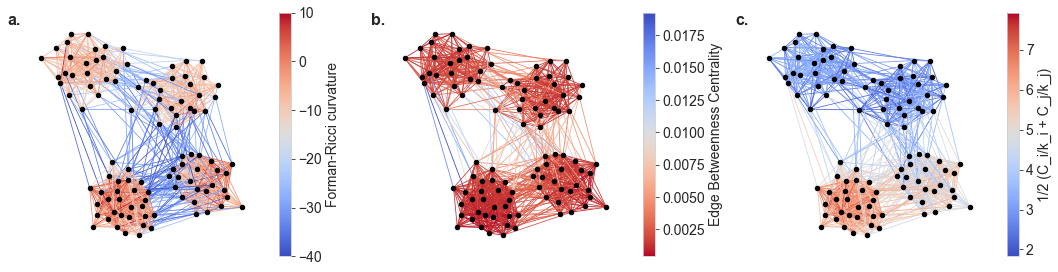

In [94]:
# Plot graph with colored edges
import climnet.utils.statistic_utils as sut
reload(sut)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15, 4))
# Froman curvature
ax = plt.subplot(131)
colors = [frc.G[u][v]['formanCurvature'] for u, v in frc.G.edges]
vmin = min(colors)
vmax = max(colors)
vmin = -40
vmax = 10
colors = sut.vmin_vmax_array(colors, vmin=vmin, vmax=vmax)

cmap = cm.coolwarm
nx.draw(G, pos=my_pos, edge_color=colors, edge_cmap=cmap, 
        vmax=vmax, width=.8, node_size=20, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='Forman-Ricci curvature')
ax.text(-0.05, 0.95, f"a.", transform=ax.transAxes, size=16, weight='bold')

# Betweenness centrality
ax = plt.subplot(132)
colors = [frc.G[u][v]['betweenness'] for u, v in frc.G.edges]
vmin = min(colors)
vmax = max(colors)
# vmin = 0.04
# vmax = 0.05
cmap = cm.coolwarm_r
nx.draw(G, pos=my_pos, edge_color=colors, edge_cmap=cmap, vmin=vmin,
        vmax=vmax, width=.8, node_size=20, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='Edge Betweenness Centrality')
ax.text(-0.05, 0.95, f"b.", transform=ax.transAxes, size=16, weight='bold')

# Cluster Coefficient / Degree ratio 
ax = plt.subplot(133)
colors = [frc.G[u][v]['cdr'] for u, v in frc.G.edges]
vmin = min(colors)
vmax = max(colors)
# vmin = 4
# vmax = 6
colors = sut.vmin_vmax_array(colors, vmin=vmin, vmax=vmax)

cmap = cm.coolwarm
nx.draw(G, pos=my_pos, edge_color=colors, edge_cmap=cmap, vmin=vmin,
        vmax=vmax, width=.8, node_size=20, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='1/2 (C_i/k_i + C_j/k_j)')
ax.text(-0.05, 0.95, f"c.", transform=ax.transAxes, size=16, weight='bold')


plt.tight_layout()
plot_dir = '/home/strnad/data/climnet/plots/enso/'
plt.savefig(plot_dir + f"toy_model/toy_comparison_forman_ebc_clustering.pdf",
            bbox_inches='tight')


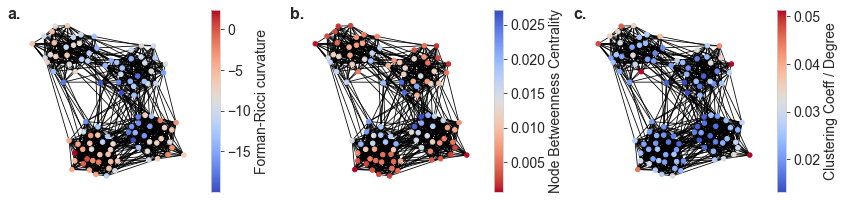

In [42]:
# Plot graph with colored nodes
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 3))
# Froman curvature
ax = plt.subplot(131)
colors = [frc.G.nodes[n]['formanCurvature'] for n in frc.G.nodes]
vmin = min(colors)
vmax = max(colors)
# vmin = -30
# vmax = 10

cmap = cm.coolwarm
nx.draw(G, pos=my_pos, node_color=colors, cmap=cmap, vmin=vmin,
        vmax=vmax, width=.8, node_size=20, edge_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='Forman-Ricci curvature')
ax.text(-0.05, 0.95, f"a.", transform=ax.transAxes, size=16, weight='bold')

# Betweenness centrality
ax = plt.subplot(132)
colors = [frc.G.nodes[n]['betweenness'] for n in frc.G.nodes]
vmin = min(colors)
vmax = max(colors)
# vmin = 0.04
# vmax = 0.05
cmap = cm.coolwarm_r
nx.draw(G, pos=my_pos, node_color=colors, cmap=cmap, vmin=vmin,
        vmax=vmax, width=.8, node_size=20, edge_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='Node Betweenness Centrality')
ax.text(-0.05, 0.95, f"b.", transform=ax.transAxes, size=16, weight='bold')


# Clustering coefficient
ax = plt.subplot(133)
colors = [frc.G.nodes[n]['clustering']/frc.G.nodes[n]['degree']
          for n in frc.G.nodes]
vmin = min(colors)
vmax = max(colors)
# vmin = 0.04
# vmax = 0.05
cmap = cm.coolwarm
nx.draw(G, pos=my_pos, node_color=colors, cmap=cmap, vmin=vmin,
        vmax=vmax, width=.8, node_size=20, edge_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='Clustering Coeff / Degree')
ax.text(-0.05, 0.95, f"c.", transform=ax.transAxes, size=16, weight='bold')


plt.tight_layout()
plot_dir = '/home/strnad/data/climnet/plots/enso/'
plt.savefig(plot_dir + f"toy_model/toy_comparison_node_forman_ebc_clustering.pdf",
            bbox_inches='tight')


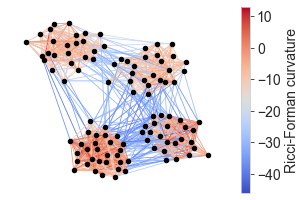

In [11]:
# Plot graph with colored edges
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(4.5,3))
# Froman curvature
ax = plt.subplot(111)
colors = [frc.G[u][v]['formanCurvature'] for u,v in orc.G.edges]
vmin = min(colors)
vmax = max(colors)
cmap = cm.coolwarm
nx.draw(G, pos=my_pos, edge_color=colors, edge_cmap=cmap, vmin=vmin, vmax=vmax, width=.8, node_size=20, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='Ricci-Forman curvature')

plt.tight_layout()
plt.savefig(os.getcwd() + "/../../outputs/toy_model_forman.pdf", bbox_inches='tight')